In [0]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Задание 3b.1**

Перед вами опять до боли знакомый набор данных детектора черенковского излучения. Ваша задача переписать классификатор из блокнота `torch.ipynb` с использованием фреймворка TensorFlow и API Keras. Почти весь код уже написан, вам осталось самостоятельно заполнить пропущенные места, используя документацию (https://www.tensorflow.org/api_docs/python/tf/keras/layers):

* Аналогом `torch.nn.Sequential` является `tf.keras.Sequential`,
* Полносвязный слой удобно задавать используя `tf.keras.layers.Dense`.

Используйте значения метапараметров (количество скрытых нейронов, скорость обучения и т.п.) определенные при работе с аналогичным заданием из блокнота `torch.ipynb`.

In [0]:
import numpy as np
import pandas as pd

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('/content/drive/My Drive/2020-hw3-propellermint/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1]).astype(np.float32)
y = np.asarray(data.iloc[:, [-1]])
y = (y == 'g').astype(np.float32)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(5)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(5)

In [5]:
tf.random.set_seed(43)

INPUT_DIM  = x.shape[1]
HIDDEN_DIM = 30 # ???
OUTPUT_DIM = y.shape[1]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(HIDDEN_DIM, activation='sigmoid'))
model.add(tf.keras.layers.Dense(OUTPUT_DIM, activation='tanh'))

#model = torch.nn.Sequential(
#    torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
#    torch.nn.Sigmoid(),
#    torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
#    torch.nn.Sigmoid(),
#)

learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='MSE', metrics=['accuracy'])

_ = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
2853/2853 [==============================] - 4s 1ms/step - loss: 0.2014 - accuracy: 0.7159 - val_loss: 0.1592 - val_accuracy: 0.7710
Epoch 2/50
2853/2853 [==============================] - 4s 1ms/step - loss: 0.1598 - accuracy: 0.7675 - val_loss: 0.1512 - val_accuracy: 0.7796
Epoch 3/50
2853/2853 [==============================] - 4s 1ms/step - loss: 0.1528 - accuracy: 0.7819 - val_loss: 0.1478 - val_accuracy: 0.7931
Epoch 4/50
2853/2853 [==============================] - 4s 1ms/step - loss: 0.1476 - accuracy: 0.7941 - val_loss: 0.1426 - val_accuracy: 0.8017
Epoch 5/50
2853/2853 [==============================] - 5s 2ms/step - loss: 0.1416 - accuracy: 0.8037 - val_loss: 0.1395 - val_accuracy: 0.8116
Epoch 6/50
2853/2853 [==============================] - 4s 1ms/step - loss: 0.1372 - accuracy: 0.8122 - val_loss: 0.1352 - val_accuracy: 0.8181
Epoch 7/50
2853/2853 [==============================] - 4s 1ms/step - loss: 0.1351 - accuracy: 0.8150 - val_loss: 0.1351 - val_accuracy:

AUC                       = 0.8813


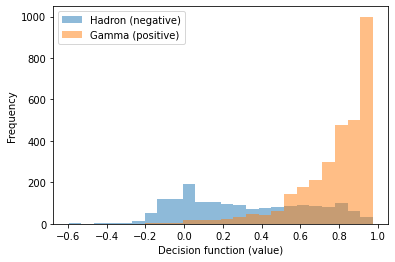

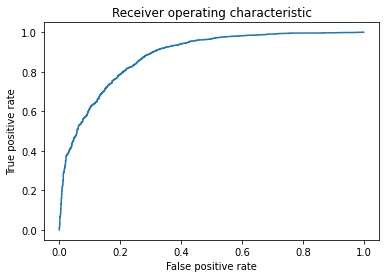

In [6]:
import sklearn.metrics

y_true = y_test
scores = model.predict(x_test)

min_score, max_score = np.min(scores), np.max(scores)
bins = np.linspace(min_score, max_score, 25)
plt.figure()
plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
plt.xlabel("Decision function (value)")
plt.ylabel("Frequency")
plt.legend()

fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
auc = sklearn.metrics.roc_auc_score(y_true, scores)
plt.figure()
plt.plot(fpr, tpr)
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
print("AUC                       = {:.4f}".format(auc))

**Задание 3b.2**

В блокноте `torch.ipynb` реализован автоэнкодер для набора рукописных цифр MNIST на базе свёрточных нейронных сетей. Настало время переписать и его с использованием фреймворка TensorFlow и API Keras.
Используйте документацию (https://www.tensorflow.org/api_docs/python/tf/keras/layers), чтобы воспроизвести известную вам существующую архитектуру с помощью нового фреймворка.

* Нарисуйте четыре случайных изображения из тестового набора данных: исходное изображение, закодированное сжатое представление в виде гистограмы, и раскодированное изображение.
* Попробуйте сгенерировать четыре случайных изображения, подав на вход декодера случайные данные.

In [0]:
tf.random.set_seed(43)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1000).batch(4)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test)).shuffle(1000).batch(4)

In [0]:
INPUT_SHAPE = (28, 28, 1) 
HIDDEN1_CH = 24 
HIDDEN2_CH = 32 
LATENT_DIM = 8 
 
def get_model(): 
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name='encoder_input') 
 
    encoder = tf.keras.Sequential([ 
    inputs, 
    tf.keras.layers.Conv2D(HIDDEN1_CH, 3, strides = 2, activation='relu'), 
    tf.keras.layers.Conv2D(HIDDEN2_CH, 3, strides=2, activation='relu',use_bias=False), 
    tf.keras.layers.Conv2D(LATENT_DIM, 6, activation='sigmoid',use_bias=False) 
    ]) 

    decoder = tf.keras.Sequential([ 
    tf.keras.layers.LayerNormalization(), 
    tf.keras.layers.Conv2DTranspose(HIDDEN2_CH, 6, activation='relu',use_bias=False), 
    tf.keras.layers.Conv2DTranspose(HIDDEN2_CH, 3, strides=2, activation='relu',use_bias=False), 
    tf.keras.layers.Conv2DTranspose(HIDDEN1_CH, 4, strides=2, activation='relu',use_bias=False), 
    tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid',use_bias=False) 
    ]) 

    autoencoder = tf.keras.Model(inputs=inputs, outputs=decoder(encoder(inputs))) 

    return autoencoder, encoder, decoder 
 
model, encoder, decoder = get_model()

In [9]:
tf.random.set_seed(41)

learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='MSE')

_ = model.fit(train_dataset, epochs=6, validation_data=test_dataset)

Epoch 1/6
15000/15000 [==============================] - 457s 30ms/step - loss: 0.0275 - val_loss: 0.0238
Epoch 2/6
15000/15000 [==============================] - 577s 38ms/step - loss: 0.0231 - val_loss: 0.0225
Epoch 3/6
15000/15000 [==============================] - 591s 39ms/step - loss: 0.0221 - val_loss: 0.0220
Epoch 4/6
15000/15000 [==============================] - 884s 59ms/step - loss: 0.0216 - val_loss: 0.0217
Epoch 5/6
15000/15000 [==============================] - 831s 55ms/step - loss: 0.0212 - val_loss: 0.0212
Epoch 6/6
15000/15000 [==============================] - 835s 56ms/step - loss: 0.0210 - val_loss: 0.0210


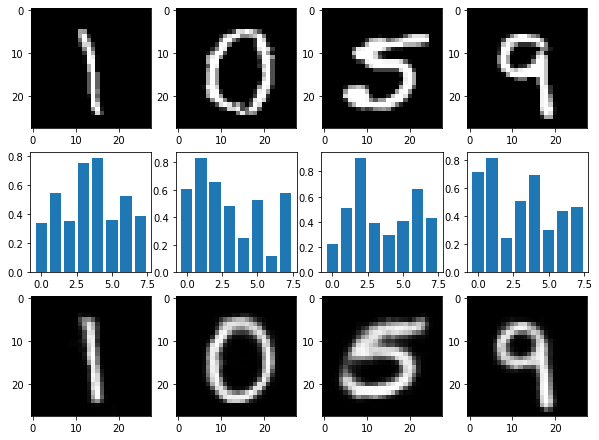

In [10]:
images, _ = iter(test_dataset).next()
plt.figure(figsize=(10, 7.5)) 
n_col = 4 
encoded = encoder(images) 
decoded = decoder(encoded) 
for i in range(n_col): 
 ax = plt.subplot(3, n_col, i + 1) 
 plt.imshow(images[i], cmap='gray') 
 ax = plt.subplot(3, n_col, i + 1 + n_col) 
 plt.bar(np.arange(8), tf.reshape(encoded[i],8)) 
 ax = plt.subplot(3, n_col, i + 1 + n_col * 2) 
 plt.imshow(tf.reshape(decoded[i], [28,28]), cmap='gray') 
 
plt.show()

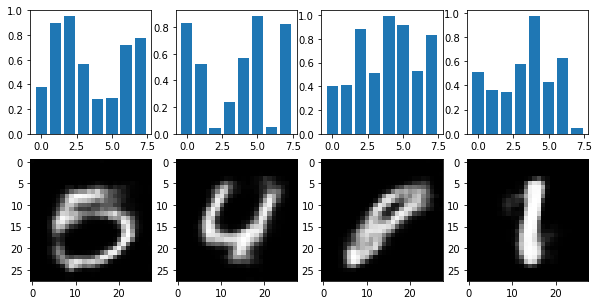

In [14]:
np.random.seed(41) 
 
encoded = tf.random.uniform((4,1,1,8)) 
decoded = decoder(encoded) 
 
plt.figure(figsize=(10, 5)) 
n_col = 4 
for i in range(n_col): 
 ax = plt.subplot(2, n_col, i + 1) 
 plt.bar(np.arange(encoded.shape[3]), tf.reshape(encoded[i,:],8)) 
 ax = plt.subplot(2, n_col, i + 1 + n_col) 
 plt.imshow(tf.reshape(decoded[i],[28,28]), cmap='gray') 
plt.show()